## Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import emoji
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.preprocessing import OneHotEncoder
#import gensim
#from gensim import corpora
#from gensim.models import LdaModel, CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
import wordcloud
import hdbscan
import plotly.express as px
import optuna
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import umap


## Limpieza

Cargamos los datos

In [36]:
raw_data = pd.read_csv('mental_disorders_reddit.csv', sep=',')

In [37]:
raw_data.head()

title  \
0  Life is so pointless without others   
1                           Cold rage?   
2                I don’t know who I am   
3              HELP! Opinions! Advice!   
4                                 help   

                                            selftext  created_utc  over_18  \
0  Does anyone else think the most important part...   1650356960    False   
1  Hello fellow friends 😄\n\nI'm on the BPD spect...   1650356660    False   
2  My [F20] bf [M20] told me today (after I said ...   1650355379    False   
3  Okay, I’m about to open up about many things I...   1650353430    False   
4                                          [removed]   1650350907    False   

  subreddit  
0       BPD  
1       BPD  
2       BPD  
3       BPD  
4       BPD

In [38]:
raw_data.dtypes, raw_data.shape

(title          object
 selftext       object
 created_utc     int64
 over_18          bool
 subreddit      object
 dtype: object,
 (701787, 5))

El dataset contiene 5 columnas:

- **title**: Título del post
- **selftext**: Texto del post
- **created_utc**: Fecha de creación del post
- **over_18**: Si el post es para mayores de 18 años
- **subreddit**: Subreddit al que pertenece el post

Son unos 700_000 registros, ya que tenemos datos de temporalidad, veamos periodos de actividad en el subreddit y comprobemos si podemos quedarnos con una porción de los datos.

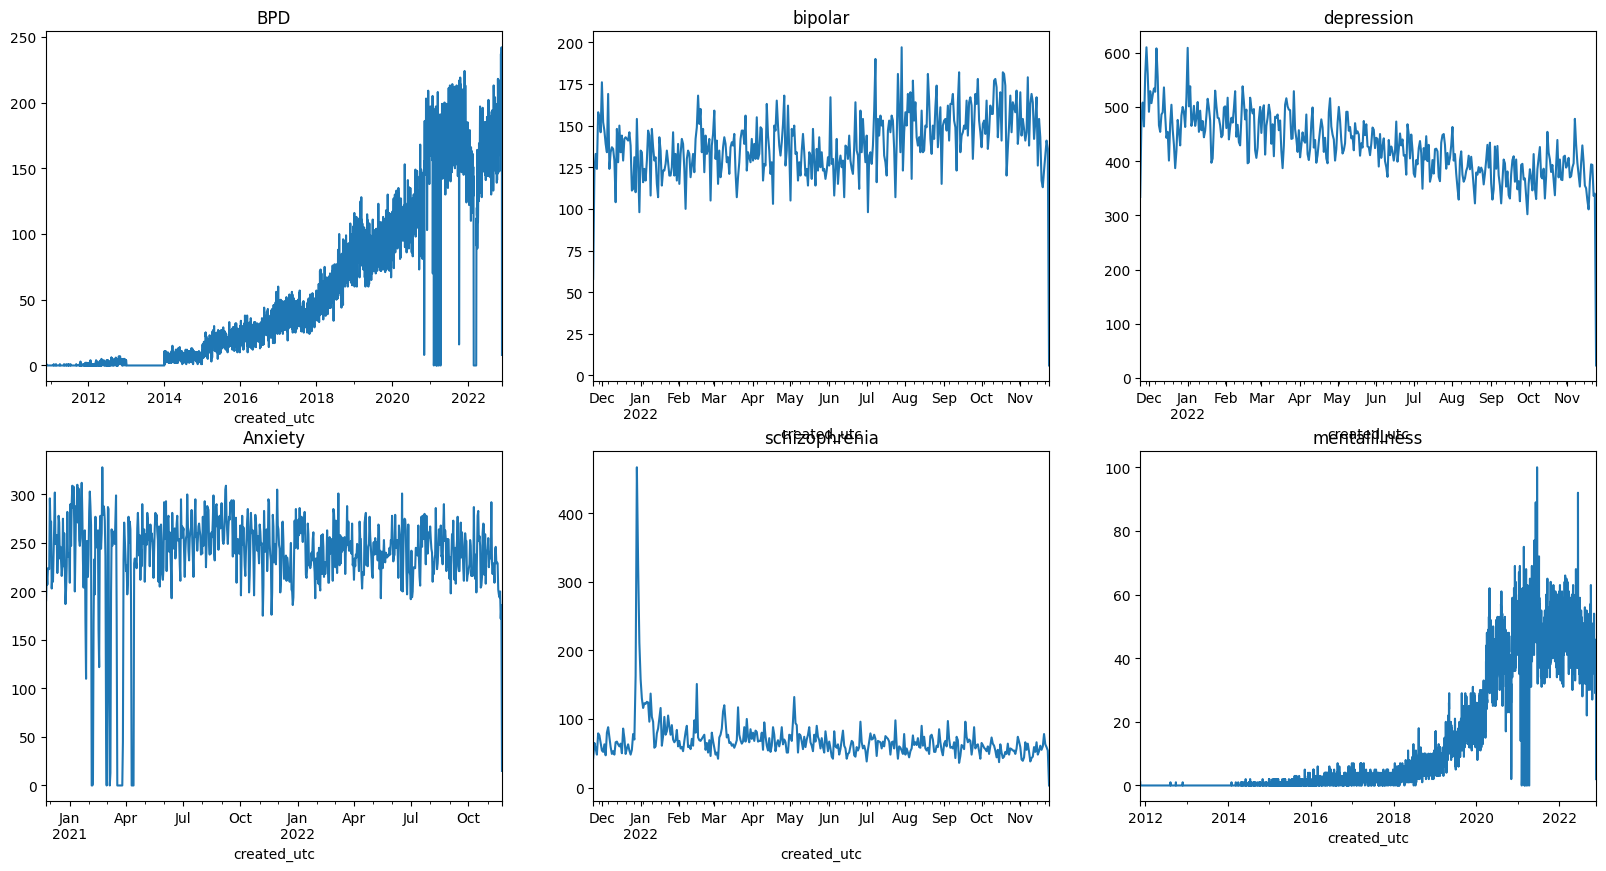

In [39]:
raw_data['created_utc'] = pd.to_datetime(raw_data['created_utc'], unit='s')

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, subreddit in enumerate(raw_data['subreddit'].unique()):
    raw_data[raw_data['subreddit'] == subreddit].resample('D', on='created_utc').size().plot(ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(subreddit)

Para reducir, voy a tomar el subreddit mas "joven" y tomar todos los posts de los demás subreddits a partir del primer post del sub más reciente, para no tener huecos vacíos en la línea temporal.

In [40]:
# get the first publication date for each subreddit and filter the data to get only the posts after that date for the whole dataset
first_pub_date = raw_data.groupby('subreddit')['created_utc'].min().max()

print('First publication date on the youngest subreddit:', first_pub_date)

First publication date on the youngest subreddit: 2021-11-24 11:01:28


In [41]:
filtered_data = raw_data[raw_data['created_utc'] >= first_pub_date]

print('Shape of the filtered data:', filtered_data.shape)

Shape of the filtered data: (392383, 5)


In [42]:
raw_data = filtered_data

La descripción del dataset indicaba que exsitían valores nulos y posts eliminados, por tanto, procedemos a eliminarlos, incluyendo los duplicados

In [43]:
raw_data.dropna(inplace=True)
removed_index = raw_data[raw_data['selftext'] == '[removed]'].index
raw_data.drop(removed_index, inplace=True)
duped_index = raw_data[raw_data.duplicated()].index
raw_data.drop(duped_index, inplace=True)

Eliminaré los saltos de línea

In [44]:
raw_data['title'] = raw_data['title'].str.replace('\n', ' ')
raw_data['selftext'] = raw_data['selftext'].str.replace('\n', ' ')

Finalmente crearé una columna con el texto procesado (eliminación de stopwords, lematización y tokenización, eliminación de emojis)

In [56]:

raw_data['processed_text'] = raw_data['title'] + ' ' + raw_data['selftext']
raw_data['processed_text'] = raw_data['processed_text'].apply(lambda x: emoji.replace_emoji(x, replace=''))
raw_data['processed_text'] = raw_data['processed_text'].str.replace('[^a-zA-Z\s]', '')
raw_data['processed_text'] = raw_data['processed_text'].str.lower()

raw_data['processed_text'].head()

0    life is so pointless without others does anyon...
1    cold rage? hello fellow friends   i'm on the b...
2    i don’t know who i am my [f20] bf [m20] told m...
3    help! opinions! advice! okay, i’m about to ope...
5    my ex got diagnosed with bpd without going int...
Name: processed_text, dtype: object

Ahora guardamos el nuevo dataframe, y vemos siguientes pasos

In [57]:
raw_data

title  \
0            Life is so pointless without others   
1                                     Cold rage?   
2                          I don’t know who I am   
3                        HELP! Opinions! Advice!   
5                   My ex got diagnosed with BPD   
...                                          ...   
666251    Is it safe to take 5-htp twice a week?   
666252                          Am I delusional?   
666253                        Idk what i have...   
666254  HELP, I WANT TO KNOW IF MY GF IS LYING??   
666255                           is this normal?   

                                                 selftext         created_utc  \
0       Does anyone else think the most important part... 2022-04-19 08:29:20   
1       Hello fellow friends 😄  I'm on the BPD spectru... 2022-04-19 08:24:20   
2       My [F20] bf [M20] told me today (after I said ... 2022-04-19 08:02:59   
3       Okay, I’m about to open up about many things I... 2022-04-19 07:30:30   
5       Without going into detail, this diagnosis expl... 2022-04-19 06:43:55   
...                                                   ...                 ...   
666251  I took 50mg twice a day the past two days and ... 2021-11-24 13:54:22   
666252  Should I be hospitalized? Am I deluded or what... 2021-11-24 13:08:51   
666253  Somedays i feel fine. Somedays I just want to ... 2021-11-24 13:06:25   
666254  TW: sexual assault/ traumatic childhood   expe... 2021-11-24 13:00:42   
666255  i have this feeling where it’s like i have to ... 2021-11-24 11:42:48   

        over_18      subreddit  \
0         False            BPD   
1         False            BPD   
2         False            BPD   
3         False            BPD   
5         False            BPD   
...         ...            ...   
666251    False  mentalillness   
666252    False  mentalillness   
666253    False  mentalillness   
666254    False  mentalillness   
666255    False  mentalillness   

                                           processed_text  
0       life is so pointless without others does anyon...  
1       cold rage? hello fellow friends   i'm on the b...  
2       i don’t know who i am my [f20] bf [m20] told m...  
3       help! opinions! advice! okay, i’m about to ope...  
5       my ex got diagnosed with bpd without going int...  
...                                                   ...  
666251  is it safe to take 5-htp twice a week? i took ...  
666252  am i delusional? should i be hospitalized? am ...  
666253  idk what i have... somedays i feel fine. somed...  
666254  help, i want to know if my gf is lying?? tw: s...  
666255  is this normal? i have this feeling where it’s...  

[298309 rows x 6 columns]

In [58]:

raw_data['processed_text'].fillna('', inplace=True)

C:\Users\vramo\AppData\Local\Temp\ipykernel_27436\4052742835.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data['processed_text'].fillna('', inplace=True)


In [59]:
raw_data.to_csv('processed_data.csv', index=False)

## Procesamiento para análisis

Ahora realizaré los embeddings de los textos originales mediante un modelo de lenguaje.

In [2]:
df = pd.read_csv('processed_data.csv')

In [3]:
df.shape

(298309, 6)

In [4]:
model = SentenceTransformer('mixedbread-ai/mxbai-embed-large-v1', truncate_dim=512)

df['full_text'] = df['title'] + ' ' + df['selftext']
df['full_text'].fillna('', inplace=True)

texts = df['full_text'].values.tolist()

embeddings = model.encode(texts, show_progress_bar=True)

C:\Users\vramo\AppData\Local\Temp\ipykernel_25724\705797857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['full_text'].fillna('', inplace=True)


Batches:   0%|          | 0/9323 [00:00<?, ?it/s]

c:\Users\vramo\miniconda3\envs\torch_env\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Además añadiré los resultados de un sentiment analysis por un modelo

In [4]:
cols = ['negative', 'neutral', 'positive']

In [11]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment

sentiments = df['full_text'].apply(get_sentiment)

sentiments = pd.DataFrame(sentiments.tolist())




Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
c:\Users\vramo\miniconda3\envs\torch_env\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\vramo\AppData\Local\Temp\ipykernel_19572\3923951834.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the ope

## Análisis

### Distribución por subreddit

In [20]:
df = pd.read_csv('processed_data.csv')
sentiments = pd.read_csv('sentiments.csv')

df = pd.concat([df, sentiments], axis=1)

In [21]:
df.head()

title  \
0  Life is so pointless without others   
1                           Cold rage?   
2                I don’t know who I am   
3              HELP! Opinions! Advice!   
4         My ex got diagnosed with BPD   

                                            selftext          created_utc  \
0  Does anyone else think the most important part...  2022-04-19 08:29:20   
1  Hello fellow friends 😄  I'm on the BPD spectru...  2022-04-19 08:24:20   
2  My [F20] bf [M20] told me today (after I said ...  2022-04-19 08:02:59   
3  Okay, I’m about to open up about many things I...  2022-04-19 07:30:30   
4  Without going into detail, this diagnosis expl...  2022-04-19 06:43:55   

   over_18 subreddit                                     processed_text  \
0    False       BPD  life is so pointless without others does anyon...   
1    False       BPD  cold rage? hello fellow friends   i'm on the b...   
2    False       BPD  i don’t know who i am my [f20] bf [m20] told m...   
3    False       BPD  help! opinions! advice! okay, i’m about to ope...   
4    False       BPD  my ex got diagnosed with bpd without going int...   

     neg    neu    pos  compound  
0  0.000  0.777  0.223    0.9564  
1  0.160  0.734  0.105   -0.9913  
2  0.046  0.884  0.070    0.4137  
3  0.085  0.761  0.153    0.9972  
4  0.040  0.775  0.185    0.9896

Veamos la distribución de los posts por subreddit

<Axes: title={'center': 'Number of posts per subreddit since 2021-11-24 11:01:28'}, xlabel='subreddit'>

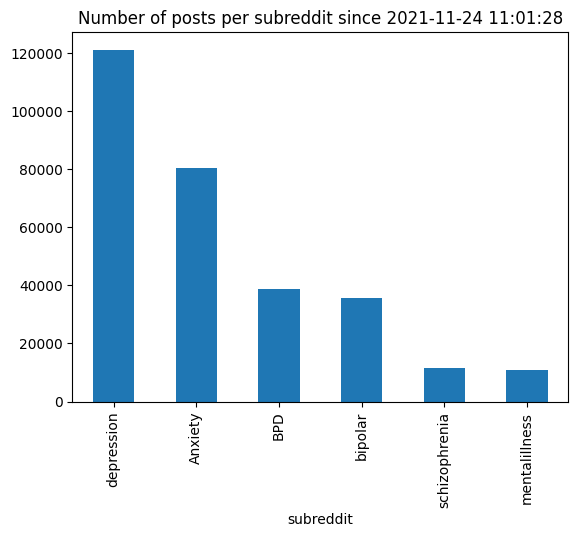

In [6]:
df.subreddit.value_counts().plot(kind='bar', title='Number of posts per subreddit since {}'.format(df['created_utc'].min()))

También incluyamos el wordcloud de los subreddits

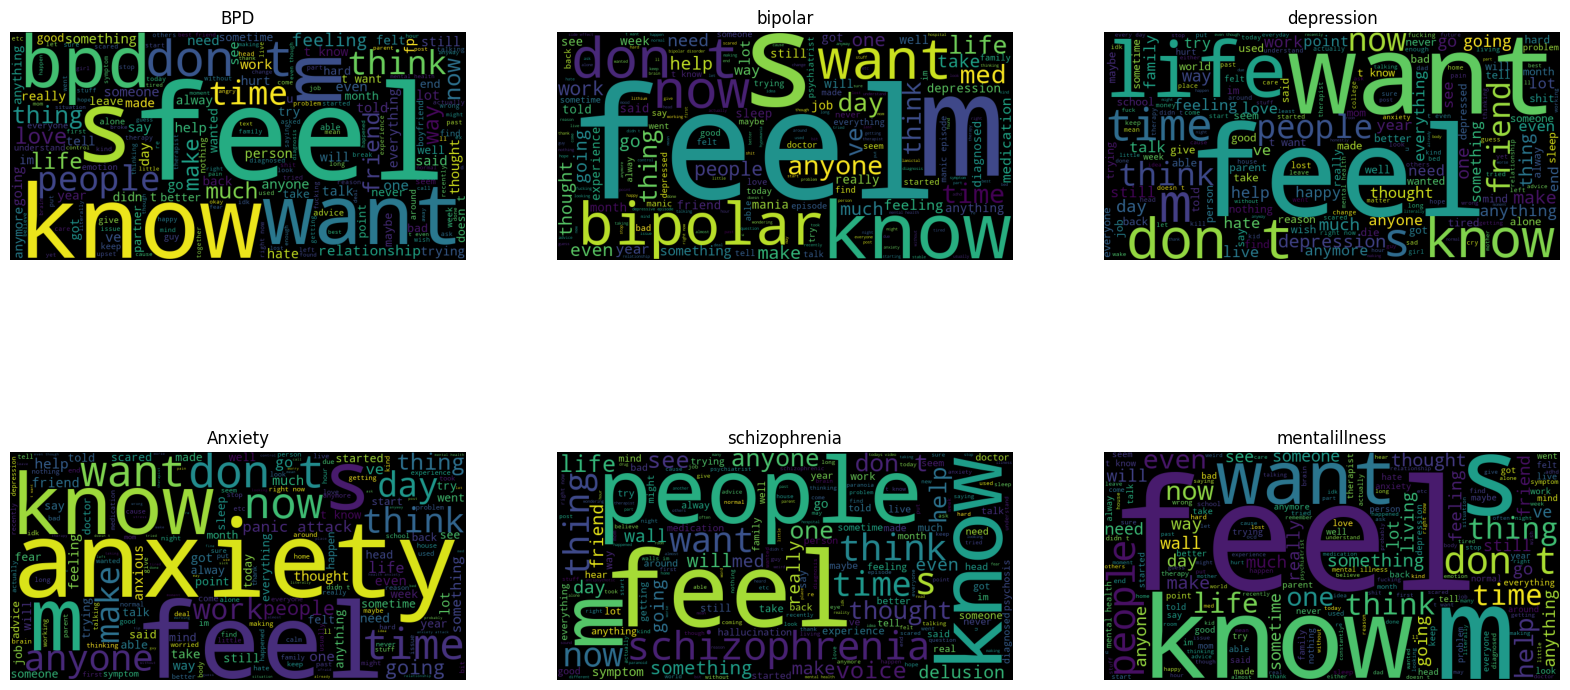

In [24]:
# plot the word cloud for each subreddit
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, subreddit in enumerate(df['subreddit'].unique()):
    text = ' '.join(df[df['subreddit'] == subreddit]['processed_text'])
    wc = wordcloud.WordCloud(width=800, height=400, max_words=200).generate(text)
    ax[i // 3, i % 3].imshow(wc)
    ax[i // 3, i % 3].set_title(subreddit)
    ax[i // 3, i % 3].axis('off')

plt.show()



Y de todo el dataset

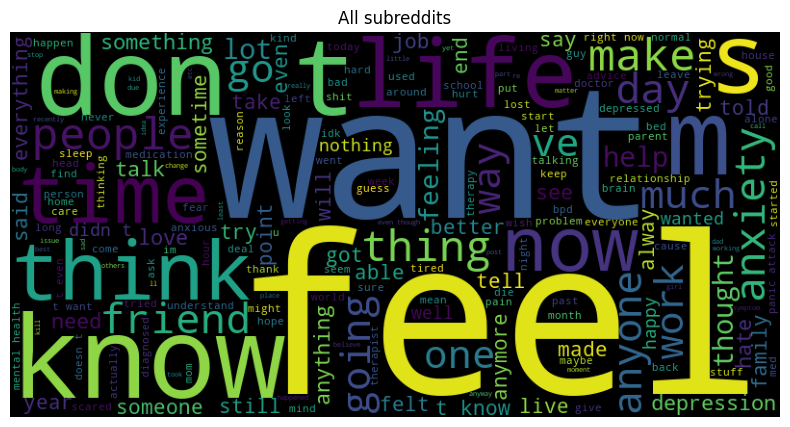

In [25]:
all_text = ' '.join(df['processed_text'])

wc = wordcloud.WordCloud(width=800, height=400, max_words=200).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc)
plt.title('All subreddits')

plt.axis('off')
plt.show()


La palabra má repetida es feel, algo que tiene sentido dada la naturaleza de los subreddits, y palabras como want y like también son comunes en todos los subs en general.

La distribución refleja la realidad de que la depresión y la ansiendad son de las enfermedades mentales más comunes en la actualidad, y por tanto, los subreddits más populares. A continuación, veremos la distribución de los sentiminientos en los posts de los distintos subs.

### Sentiment Analysis

Means:
                    neg       neu       pos  compound
subreddit                                            
Anxiety        0.150430  0.747716  0.101853 -0.298019
BPD            0.131746  0.750189  0.118069 -0.131368
bipolar        0.113339  0.780767  0.105895 -0.071909
depression     0.164051  0.719515  0.116433 -0.318932
mentalillness  0.139491  0.757109  0.103387 -0.295022
schizophrenia  0.096912  0.799795  0.103294  0.010531

Medians:
                 neg    neu    pos  compound
subreddit                                   
Anxiety        0.143  0.752  0.095   -0.6727
BPD            0.127  0.751  0.113   -0.4832
bipolar        0.106  0.783  0.098   -0.1612
depression     0.155  0.724  0.110   -0.7264
mentalillness  0.135  0.759  0.097   -0.7003
schizophrenia  0.087  0.801  0.092    0.0000


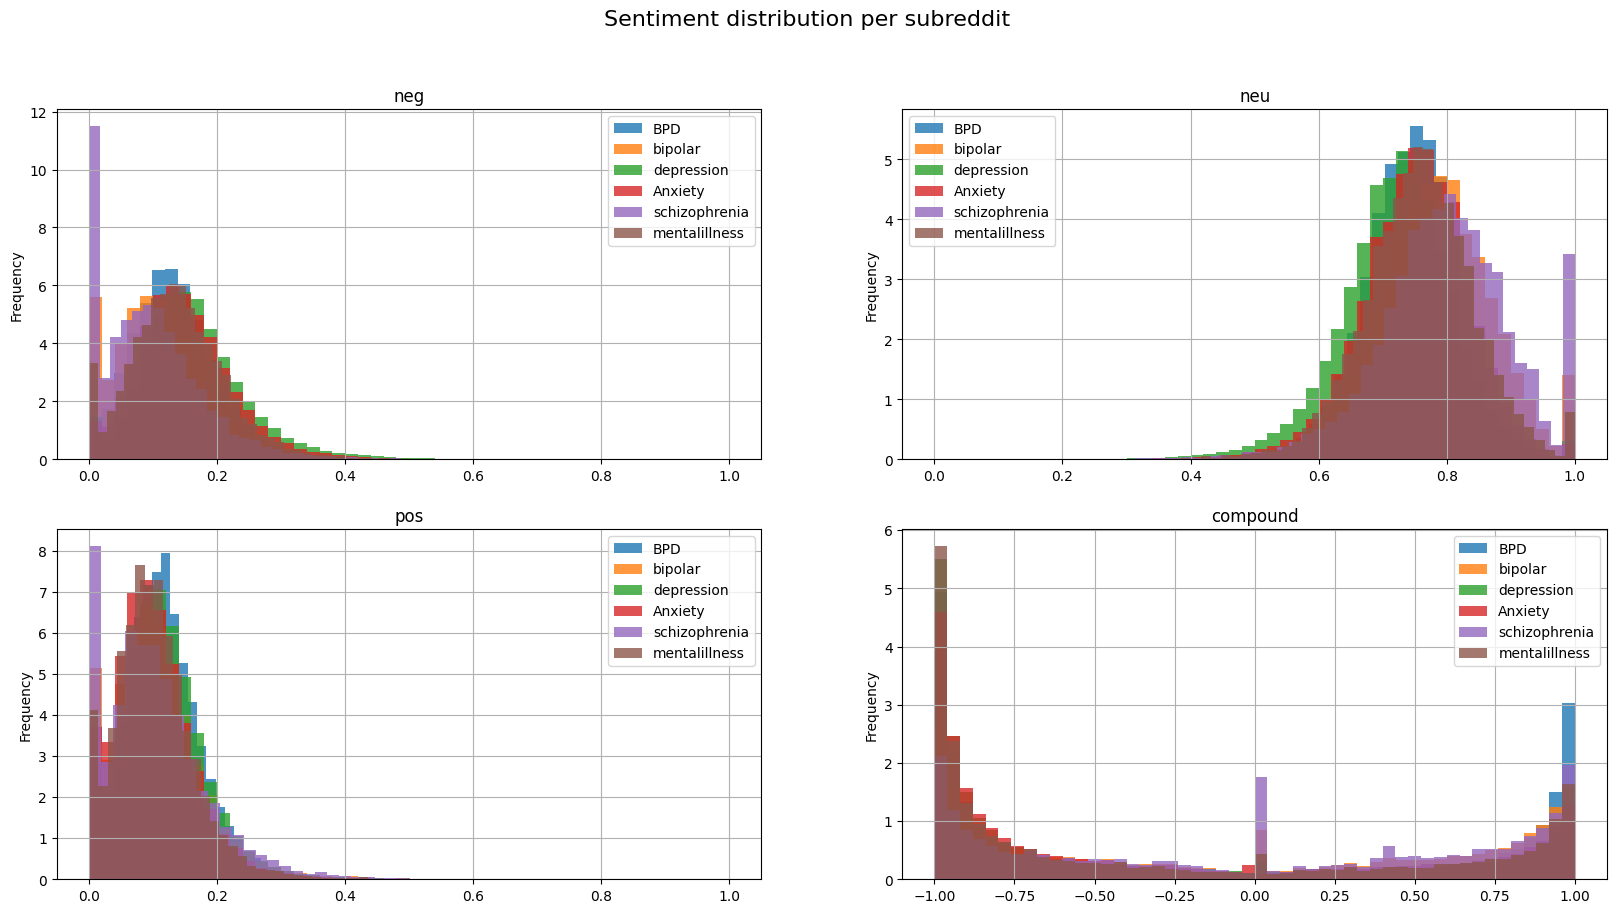

In [33]:
# for each sentiment, plot the histogram of the number of posts per subreddit
sentiments = ['neg', 'neu', 'pos', 'compound']
subreddits = df['subreddit'].unique()

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for i, sentiment in enumerate(sentiments):

    for j, subreddit in enumerate(subreddits):
        df[df['subreddit'] == subreddit][sentiment].plot(kind='hist', ax=ax[i // 2, i % 2], alpha=0.8, label=subreddit, density=True, bins = 50)
        ax[i // 2, i % 2].set_title(sentiment)
        ax[i // 2, i % 2].legend()
        ax[i // 2, i % 2].grid(True)


# title of the whole plot
plt.suptitle('Sentiment distribution per subreddit', fontsize=16)

# print the mean for each sentiment per subreddit
means = df.groupby('subreddit')[sentiments].mean()
medians = df.groupby('subreddit')[sentiments].median()
print('Means:')
print(means)
print()
print('Medians:')
print(medians)

Las distribuciones son similares, schizophrenia parece ser el más polarizado.

Compound es uno de los valores que se obtienen en el análisis de sentimientos, y es una combinación de los valores de negatividad, positividad y neutralidad, basandose en el análisis de las palabras del texto. Veamos la distribución de los valores de compound en los distintos subreddits y si se pueden discernir diferencias entre ellos.

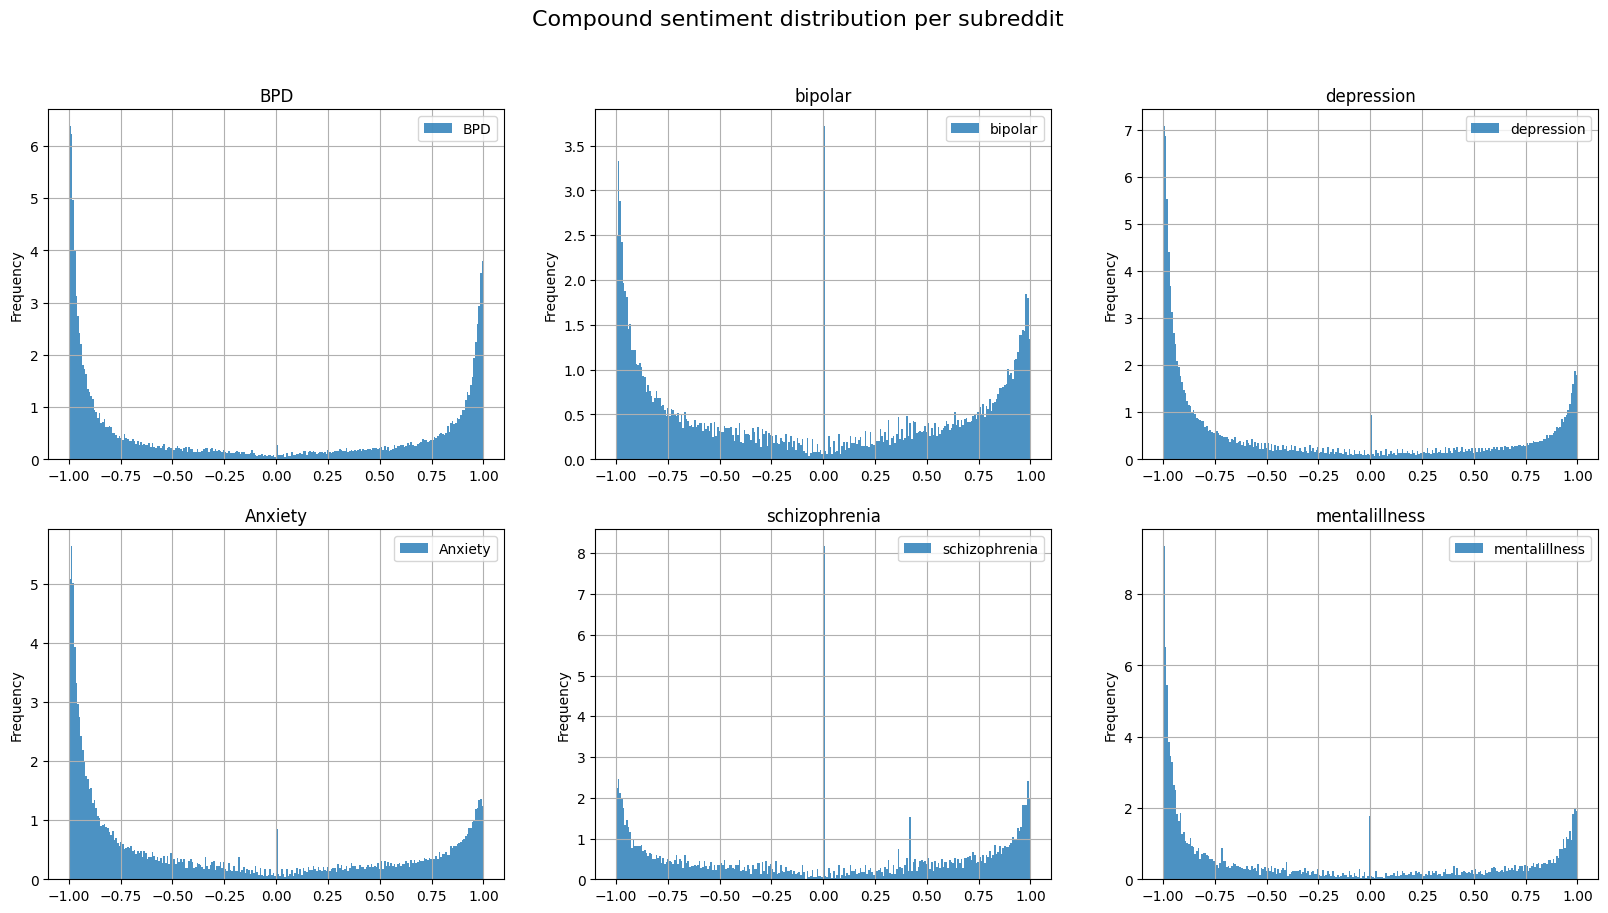

In [34]:
# plot histograms of compund sentiment for each subreddit
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

plt.suptitle('Compound sentiment distribution per subreddit', fontsize=16)

for i, subreddit in enumerate(df['subreddit'].unique()):
    df[df['subreddit'] == subreddit]['compound'].plot(kind='hist', ax=ax[i // 3, i % 3], alpha=0.8, label=subreddit, density=True, bins=250)
    ax[i // 3, i % 3].set_title(subreddit)
    ax[i // 3, i % 3].legend()
    ax[i // 3, i % 3].grid(True)



    

- **BPD (Borderline Personality Disorder)**:

    La distribución tiene forma de "U", con muchos comentarios polarizados, tanto en los extremos negativos (-1.00) como positivos (1.00). Los comentarios neutros (cercanos a 0) son menos frecuentes.


- **Bipolar**:

    También muestra una distribución en forma de "U", aunque con un pico significativo alrededor de 0. Esto sugiere que los comentarios en este subreddit son más polarizados, pero con una tendencia leve hacia la neutralidad.


- **Depression**:

    Este subreddit tiene una fuerte inclinación hacia los sentimientos negativos, con un pico considerable alrededor de -1.00. Aunque hay una pequeña cantidad de comentarios positivos, predominan los comentarios negativos.


- **Anxiety**:

    Al igual que los otros subreddits, muestra una distribución en forma de "U", con una alta frecuencia de comentarios en los extremos negativos y positivos. Sin embargo, los comentarios cercanos al 0 son más frecuentes que en algunos de los otros subreddits.


- **Schizophrenia**:

    Tiene una distribución bastante polarizada, con picos significativos tanto en el extremo negativo como positivo. Parece que las emociones expresadas en este subreddit son altamente intensas.


- **Mentalillness**:

    Este subreddit muestra una fuerte polarización con picos en ambos extremos, pero los comentarios negativos parecen ser más predominantes.

Por último, veamos si varían los sentimientos a lo largo del tiempo en los distintos subreddits

/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_66266/2311965281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['created_utc'] = pd.to_datetime(sub_df['created_utc'])
/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_66266/2311965281.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sub_df.resample('M', on='created_utc')[['compound']].mean().plot(ax=ax[i])
/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_66266/2311965281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Text(0.5, 0.98, 'Media mensual de compound por subreddit')

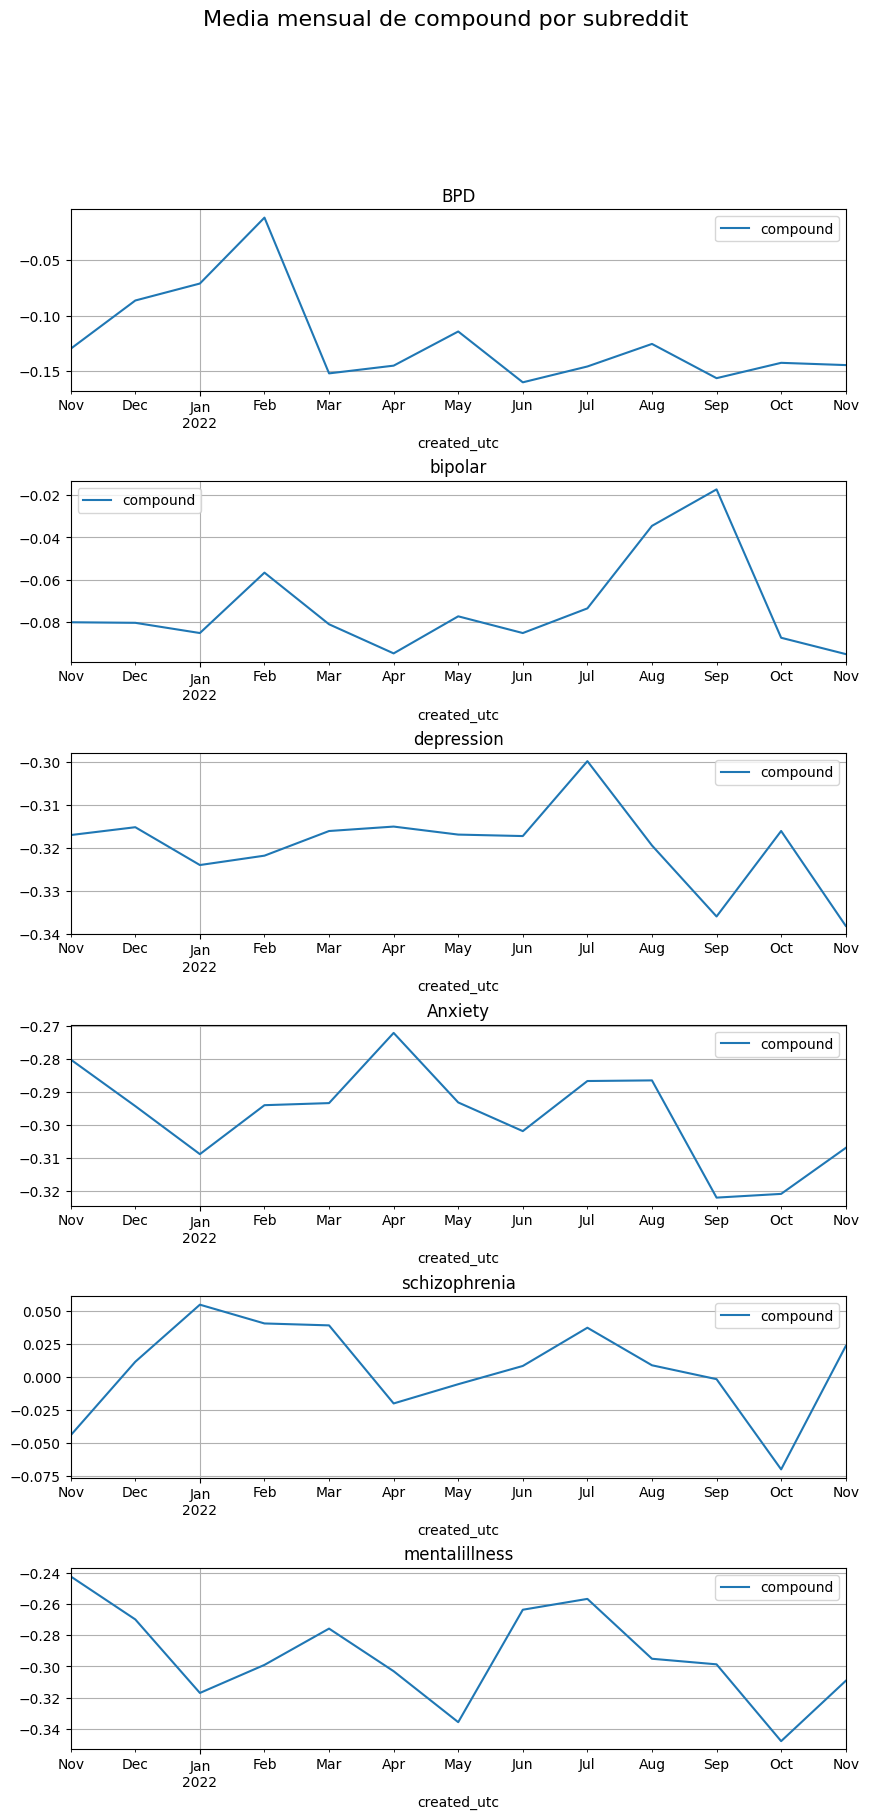

In [46]:

fig, ax = plt.subplots(6, 1, figsize=(10, 20))
# adjust the space between the plots
plt.subplots_adjust(hspace=0.5)

for i, subreddit in enumerate(df['subreddit'].unique()):
    sub_df = df.loc[df['subreddit'] == subreddit]
    sub_df['created_utc'] = pd.to_datetime(sub_df['created_utc'])
    sub_df.resample('M', on='created_utc')[['compound']].mean().plot(ax=ax[i])
    ax[i].set_title(subreddit)
    ax[i].grid(True)

plt.suptitle('Media mensual de compound por subreddit', fontsize=16)


Conclusiones:

- Como se había reflejado en los histogramas, BPD, Bipolar y schizophrenia son los subreddits más polarizados, con una mayor cantidad de comentarios en los extremos negativos y positivos, llevamos a medias más cercanas a 0.

- Depression y mentalillness tienen una tendencia más negativa, con una mayor cantidad de comentarios en el extremo negativo a lo largo del tiempo, con picos de negatividad a final de año en el caso de r/depression, y una periodicidad de 4 meses aproximadamente en r/mentalillness.

- Anxiety tiene picos de negatividad a final y principios de año, y una tendencia positiva en los meses de verano, eso puede ser debido a que la mayoría de los usuarios de este subreddit son estudiantes y sufren más ansiedad en épocas de exámenes.

### NSFW

Seguidamente, los posts también contienen una marca de si es contenido +18, puede ser interesante ver si hay diferencias en los sentimientos de los posts en función de si son +18 o no. Y dados los embeddings, ¿podemos crear un modelo de clasificación para predecir si un post es +18 o no?

In [7]:
# plot the correlation between sentiment and over_18

df[['neg', 'neu', 'pos', 'compound', 'over_18']].corr()



neg       neu       pos  compound   over_18
neg       1.000000 -0.710035 -0.240502 -0.626338  0.041584
neu      -0.710035  1.000000 -0.512714  0.116397 -0.028308
pos      -0.240502 -0.512714  1.000000  0.603206 -0.011672
compound -0.626338  0.116397  0.603206  1.000000 -0.048369
over_18   0.041584 -0.028308 -0.011672 -0.048369  1.000000

Respecto a sentimientos, no parecen afectar enormemente a la correlación, por tanto no existe una relación clara entre los sentimientos y si un post es nsfw o no. 

Finalment respecto a los post +18, veamos si podemos entrenar un modelo que pueda predecir si un post es +18 o no.

In [8]:

class NSFWNet(nn.Module):
    def __init__(self, input_dim, num_hidden=3, hidden_dim=256, dropout=None, output_dim=1):
        super(NSFWNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout) if dropout is not None else None

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            if self.dropout is not None:
                x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
embeddings = torch.tensor(np.load('embeddings.npy'), dtype=torch.float32)
sentiments = torch.tensor(df[['neg', 'neu', 'pos', 'compound']].values, dtype=torch.float32)
over_18 = torch.tensor(df['over_18'].values, dtype=torch.float32).float().view(-1, 1)

X = torch.cat([embeddings, sentiments], dim=1)
print(X.shape)  
y = over_18
print(y.shape)

torch.Size([298309, 516])
torch.Size([298309, 1])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([214782, 516]) torch.Size([23865, 516]) torch.Size([59662, 516])


In [22]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
val_ds = torch.utils.data.TensorDataset(X_val, y_val)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)


In [23]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: mps


In [93]:
def train(model, train_dl, val_dl, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.inference_mode():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = criterion(output, y)
                val_loss += loss.item()
            val_loss /= len(val_dl)
            val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return train_losses, val_losses

No hay que olvidar dar más peso a la clase de over_18, ya que es la clase minoritaria.

Epoch 1/10, Train Loss: 1.9144, Val Loss: 1.8517
Epoch 2/10, Train Loss: 1.7868, Val Loss: 1.8102
Epoch 3/10, Train Loss: 1.7483, Val Loss: 1.8487
Epoch 4/10, Train Loss: 1.7070, Val Loss: 1.8217
Epoch 5/10, Train Loss: 1.6511, Val Loss: 1.9359
Epoch 6/10, Train Loss: 1.5865, Val Loss: 1.9978
Epoch 7/10, Train Loss: 1.5284, Val Loss: 1.9808
Epoch 8/10, Train Loss: 1.4578, Val Loss: 2.5728
Epoch 9/10, Train Loss: 1.4028, Val Loss: 2.3517
Epoch 10/10, Train Loss: 1.3342, Val Loss: 2.8630


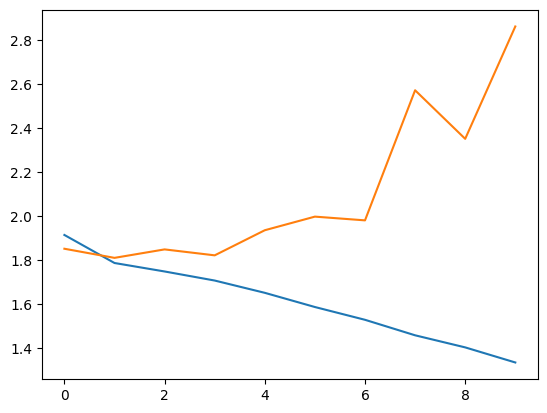

In [33]:

weight = torch.tensor([100.], dtype=torch.float32).to(device)

model = NSFWNet(input_dim=X_train.shape[1], num_hidden=2, hidden_dim=256, dropout=0.4, output_dim=1).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = train(model, train_dl, val_dl, criterion, optimizer, device, epochs=10)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend
plt.show()

In [34]:
model.eval()
y_pred = []
y_true = []
with torch.inference_mode():
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        output = model(X)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()
        y = y.cpu().numpy()
        output = np.round(output)
        y_pred.extend(output)
        y_true.extend(y)


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.57      0.73     57545
         1.0       0.07      0.87      0.13      2117

    accuracy                           0.59     59662
   macro avg       0.53      0.72      0.43     59662
weighted avg       0.96      0.59      0.71     59662



En este caso, he decidio dar una mayor importancia al recall, ya que es más importante que no se clasifiquen como no +18 posts que sí lo son, que clasificar como +18 posts que no lo son. Aunque está claro que la tarea es complicada, ya que los textos no tienen una relación clara con si son +18 o no, debido a la subjetividad de la clasificación realizada por los moderadores de los respectivos subreddits y que cada subreddit puede tener distintas normas de moderación.

Tengo la teoría de que un modleo como este sería de gran utilidad si se usa en un único subreddit, por lo que tomaré los posts de r/depression y entrenaré un modelo para predecir si un post es +18 o no dentro de este subreddit.

In [43]:
indexes = df[df['subreddit'] == 'depression'].index
embeddings_depression = torch.tensor(embeddings[indexes], dtype=torch.float32)
sentiments_depression = torch.tensor(df.loc[indexes, ['neg', 'neu', 'pos', 'compound']].values, dtype=torch.float32)
embeddings_depression = torch.cat([embeddings_depression, sentiments_depression], dim=1)
over_18_depression = torch.tensor(df.loc[indexes, 'over_18'].values, dtype=torch.float32).float().view(-1, 1)
embeddings_depression.shape, over_18_depression.shape

/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_7246/889461620.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_depression = torch.tensor(embeddings[indexes], dtype=torch.float32)


(torch.Size([121084, 516]), torch.Size([121084, 1]))

<Axes: xlabel='over_18'>

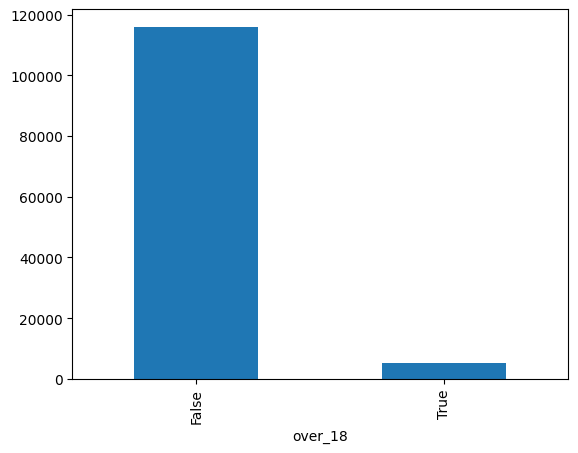

In [44]:
df.loc[indexes, 'over_18'].value_counts().plot(kind='bar')

Los posts nsfw están desbalanceados nuevamente, por lo que volveré a aplicar pesos a las clases, pero dado que se hace para un solo subreddit, debería arronjar mejores resultados.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_depression, over_18_depression, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
val_ds = torch.utils.data.TensorDataset(X_val, y_val)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)


Epoch 1/10, Train Loss: 1.2328, Val Loss: 1.1736
Epoch 2/10, Train Loss: 1.1466, Val Loss: 1.1484
Epoch 3/10, Train Loss: 1.1200, Val Loss: 1.1507
Epoch 4/10, Train Loss: 1.0925, Val Loss: 1.1383
Epoch 5/10, Train Loss: 1.0621, Val Loss: 1.1498
Epoch 6/10, Train Loss: 1.0236, Val Loss: 1.2048
Epoch 7/10, Train Loss: 0.9730, Val Loss: 1.1837
Epoch 8/10, Train Loss: 0.9147, Val Loss: 1.2957
Epoch 9/10, Train Loss: 0.8582, Val Loss: 1.4186
Epoch 10/10, Train Loss: 0.8048, Val Loss: 1.6183


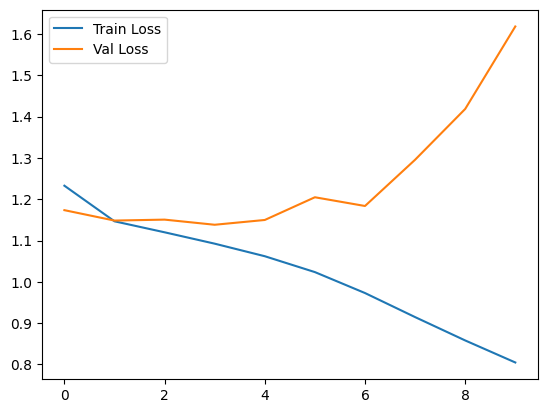

In [46]:
model = NSFWNet(input_dim=embeddings_depression.shape[1], num_hidden=3, hidden_dim=256, dropout=0.4, output_dim=1).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([25.], dtype=torch.float32).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = train(model, train_dl, val_dl, criterion, optimizer, device, epochs=10)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [47]:
model.eval()
y_pred = []
y_true = []
with torch.inference_mode():
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        output = model(X)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()
        y = y.cpu().numpy()
        output = np.round(output)
        y_pred.extend(output)
        y_true.extend(y)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     23201
         1.0       0.09      0.66      0.16      1016

    accuracy                           0.71     24217
   macro avg       0.54      0.69      0.49     24217
weighted avg       0.94      0.71      0.80     24217



La subjetividad parece seguir mermando los resultados, se necesitaría más información para poder clasificar correctamente los posts. Además existen miles de anécdotas de moderadores de reddit que han utilizado sus opiniones personales para moderar, lo que puede llevar a una clasificación incorrecta de los posts.

### LDA

A continuación, de aplicaré LDA para descubrir los temas más comunes en todos los posts y ver si cambian en función del subreddit y del tiempo.

In [2]:
df = pd.read_csv('processed_data.csv')

Para ello debemos tokenizar y lematizar los textos, y después aplicar LDA.

In [3]:
stop_words = set(stopwords.words('english'))

def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

In [19]:
df['tokens'] = df['processed_text'].apply(tokenize)

In [20]:
df.processed_text.head(), df.tokens.head()

(0    life is so pointless without others does anyon...
 1    cold rage? hello fellow friends   i'm on the b...
 2    i don’t know who i am my [f20] bf [m20] told m...
 3    help! opinions! advice! okay, i’m about to ope...
 4    my ex got diagnosed with bpd without going int...
 Name: processed_text, dtype: object,
 0    [life, pointless, without, others, anyone, els...
 1    [cold, rage, hello, fellow, friends, bpd, spec...
 2    [know, bf, told, today, said, wish, could, bet...
 3    [help, opinions, advice, okay, open, many, thi...
 4    [ex, got, diagnosed, bpd, without, going, deta...
 Name: tokens, dtype: object)

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

df['lemmas'] = df['tokens'].apply(lemmatize)

In [6]:
df = pd.read_csv('processed_data_plus.csv')

In [3]:
df.head()

title  \
0  Life is so pointless without others   
1                           Cold rage?   
2                I don’t know who I am   
3              HELP! Opinions! Advice!   
4         My ex got diagnosed with BPD   

                                            selftext          created_utc  \
0  Does anyone else think the most important part...  2022-04-19 08:29:20   
1  Hello fellow friends 😄  I'm on the BPD spectru...  2022-04-19 08:24:20   
2  My [F20] bf [M20] told me today (after I said ...  2022-04-19 08:02:59   
3  Okay, I’m about to open up about many things I...  2022-04-19 07:30:30   
4  Without going into detail, this diagnosis expl...  2022-04-19 06:43:55   

   over_18 subreddit                                     processed_text  \
0    False       BPD  life is so pointless without others does anyon...   
1    False       BPD  cold rage? hello fellow friends   i'm on the b...   
2    False       BPD  i don’t know who i am my [f20] bf [m20] told m...   
3    False       BPD  help! opinions! advice! okay, i’m about to ope...   
4    False       BPD  my ex got diagnosed with bpd without going int...   

                                              tokens  \
0  ['life', 'pointless', 'without', 'others', 'an...   
1  ['cold', 'rage', 'hello', 'fellow', 'friends',...   
2  ['know', 'bf', 'told', 'today', 'said', 'wish'...   
3  ['help', 'opinions', 'advice', 'okay', 'open',...   
4  ['ex', 'got', 'diagnosed', 'bpd', 'without', '...   

                                              lemmas  
0  ['life', 'pointless', 'without', 'other', 'any...  
1  ['cold', 'rage', 'hello', 'fellow', 'friend', ...  
2  ['know', 'bf', 'tell', 'today', 'say', 'wish',...  
3  ['help', 'opinion', 'advice', 'okay', 'open', ...  
4  ['ex', 'get', 'diagnose', 'bpd', 'without', 'g...

Una vez hecho esto preparamos los datos para LDA, y aplicamos el modelo.

In [4]:
lemmas = [eval(val) for val in df.lemmas.values]

id2word = corpora.Dictionary(lemmas)
texts = lemmas
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=8, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=1,
                                            alpha='auto',
                                            per_word_topics=True)

In [6]:
lda_model.print_topics(num_words=25)

[(0,
  '0.192*"I" + 0.186*"not" + 0.165*"m" + 0.096*"do" + 0.069*"can" + 0.033*"ve" + 0.030*"s" + 0.012*"i" + 0.010*"be" + 0.009*"that" + 0.009*"d" + 0.008*"what" + 0.006*"will" + 0.005*"ill" + 0.005*"have" + 0.005*"there" + 0.004*"wash" + 0.004*"he" + 0.003*"staff" + 0.003*"hungry" + 0.003*"skinny" + 0.003*"scared" + 0.003*"idk" + 0.003*"addicted" + 0.003*"re"'),
 (1,
  '0.037*"trauma" + 0.036*"mother" + 0.035*"child" + 0.032*"memory" + 0.029*"abuse" + 0.024*"dad" + 0.022*"childhood" + 0.019*"father" + 0.014*"kid" + 0.013*"bully" + 0.013*"member" + 0.011*"abusive" + 0.009*"remember" + 0.008*"delusional" + 0.008*"destroy" + 0.008*"baby" + 0.007*"raise" + 0.007*"police" + 0.007*"vision" + 0.007*"minor" + 0.007*"grow" + 0.007*"daydream" + 0.007*"mom" + 0.006*"son" + 0.006*"victim"'),
 (2,
  '0.062*"friend" + 0.061*"talk" + 0.058*"people" + 0.054*"say" + 0.037*"love" + 0.034*"someone" + 0.032*"person" + 0.029*"tell" + 0.019*"relationship" + 0.019*"see" + 0.016*"one" + 0.014*"want" + 0.013

- **Tema 0**: Se refiere a una narrativa interna y autopercepciones. Es común en personas que están luchando con su identidad o control de sus pensamientos, posiblemente asociado a la depresión, ansiedad o síntomas de confusión. Palabras como “not”, “can”, “scared” y “addicted” sugieren sensaciones de impotencia y miedo.

- **Tema 1**: Este tema gira en torno al trauma infantil y familiar. Palabras como “trauma”, “abuse”, “mother”, “father”, y “childhood” sugieren una discusión sobre el abuso o experiencias traumáticas en la infancia que afectan la salud mental a lo largo del tiempo.

- **Tema 2**: Se centra en relaciones sociales, tanto románticas como amistades. “Friend”, “talk”, “love” y “relationship” son términos que destacan el impacto de las relaciones en la salud mental, que puede relacionarse con trastornos de la personalidad, ansiedad social o depresión.

- **Tema 3**: Este tema está enfocado en el tratamiento médico. “Therapist”, “medication”, “doctor”, y “anxiety” sugieren una discusión sobre la búsqueda de ayuda profesional, medicamentos y la gestión de trastornos como ansiedad, pánico u OCD (trastorno obsesivo-compulsivo).

- **Tema 4**: Habla sobre la vida diaria y el impacto de la enfermedad mental en áreas como el trabajo, la escuela o la familia. Términos como “live”, “mental”, “work” y “illness” sugieren preocupaciones sobre cómo lidiar con la enfermedad mental en el entorno cotidiano.

- **Tema 5**: Refleja emociones generales y la lucha interna. Palabras como “feel”, “like”, “think” y “want” sugieren que las personas hablan sobre sus sentimientos, pensamientos y dificultades para encontrar significado o motivación, lo cual es típico en personas que luchan con depresión o ansiedad.

- **Tema 6**: Describe rutinas diarias y acciones, posiblemente relacionadas con cómo la salud mental afecta la vida cotidiana. “Go”, “get”, “day”, y “sleep” indican problemas con la energía o el sueño, lo que es común en trastornos como la depresión o el trastorno bipolar.

- **Tema 7**: Este tema agrupa diagnósticos y síntomas específicos. Palabras como “anxiety”, “depression”, “disorder”, y “bipolar” se centran en la discusión de diagnósticos, síntomas y trastornos específicos, como la ansiedad, depresión, bipolaridad y TLP, con un enfoque en la experiencia personal y las preguntas sobre tratamiento.

Evaluamos el modelo con un score de coherencia, y vemos los resultados.

In [12]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4564793698045936


Es un score aceptable, por lo que podemos seguir adelante.

In [13]:
topics = [lda_model.get_document_topics(id2word.doc2bow(text)) for text in lemmas]

In [9]:
print(topics[0])

[(2, 0.09485714), (3, 0.054677337), (4, 0.11149964), (5, 0.5848615), (6, 0.09421713), (7, 0.04775965)]


In [14]:
topic_scores = {i: [] for i in range(8)}
for post in topics:
    aux = {i: 0.0 for i in range(8)}
    for topic in post:
        aux[topic[0]] = topic[1]

    for i in range(8):
        topic_scores[i].append(aux[i])

topic_scores_df = pd.DataFrame(topic_scores)
topic_scores_df.head()


0        1         2         3         4         5         6         7
0  0.0  0.00000  0.094857  0.054677  0.111499  0.584862  0.094217  0.047760
1  0.0  0.03753  0.073128  0.039489  0.164682  0.404955  0.205576  0.073682
2  0.0  0.00000  0.159269  0.046327  0.085086  0.536723  0.096446  0.066042
3  0.0  0.00000  0.213439  0.034568  0.073724  0.266849  0.388139  0.018026
4  0.0  0.01369  0.099458  0.046840  0.195920  0.244985  0.220143  0.176735

In [48]:
topic_scores_df = pd.read_csv('topic_scores.csv')

In [49]:
df = pd.concat([df, topic_scores_df], axis=1)

In [50]:
df = df[['lemmas', 'subreddit','over_18', '0', '1', '2', '3', '4', '5', '6', '7']]

In [51]:
df.head()

lemmas subreddit  over_18    0  \
0  ['life', 'pointless', 'without', 'other', 'any...       BPD    False  0.0   
1  ['cold', 'rage', 'hello', 'fellow', 'friend', ...       BPD    False  0.0   
2  ['know', 'bf', 'tell', 'today', 'say', 'wish',...       BPD    False  0.0   
3  ['help', 'opinion', 'advice', 'okay', 'open', ...       BPD    False  0.0   
4  ['ex', 'get', 'diagnose', 'bpd', 'without', 'g...       BPD    False  0.0   

         1         2         3         4         5         6         7  
0  0.00000  0.094857  0.054677  0.111499  0.584862  0.094217  0.047760  
1  0.03753  0.073128  0.039489  0.164682  0.404955  0.205576  0.073682  
2  0.00000  0.159269  0.046327  0.085086  0.536723  0.096446  0.066042  
3  0.00000  0.213439  0.034568  0.073724  0.266849  0.388139  0.018026  
4  0.01369  0.099458  0.046840  0.195920  0.244985  0.220143  0.176735

                      0         1         2         3         4         5  \
subreddit                                                                   
Anxiety        0.011924  0.013148  0.052809  0.075743  0.121156  0.389222   
BPD            0.014037  0.015281  0.108864  0.037393  0.108665  0.425935   
bipolar        0.009975  0.014776  0.055184  0.092754  0.127654  0.369791   
depression     0.016750  0.016332  0.074996  0.039674  0.134902  0.447051   
mentalillness  0.016672  0.020232  0.067657  0.050328  0.127462  0.422562   
schizophrenia  0.012504  0.019877  0.062989  0.074455  0.123411  0.385271   

                      6         7  
subreddit                          
Anxiety        0.248415  0.081194  
BPD            0.204315  0.079483  
bipolar        0.213110  0.110473  
depression     0.209676  0.054604  
mentalillness  0.205799  0.083818  
schizophrenia  0.203361  0.112285  


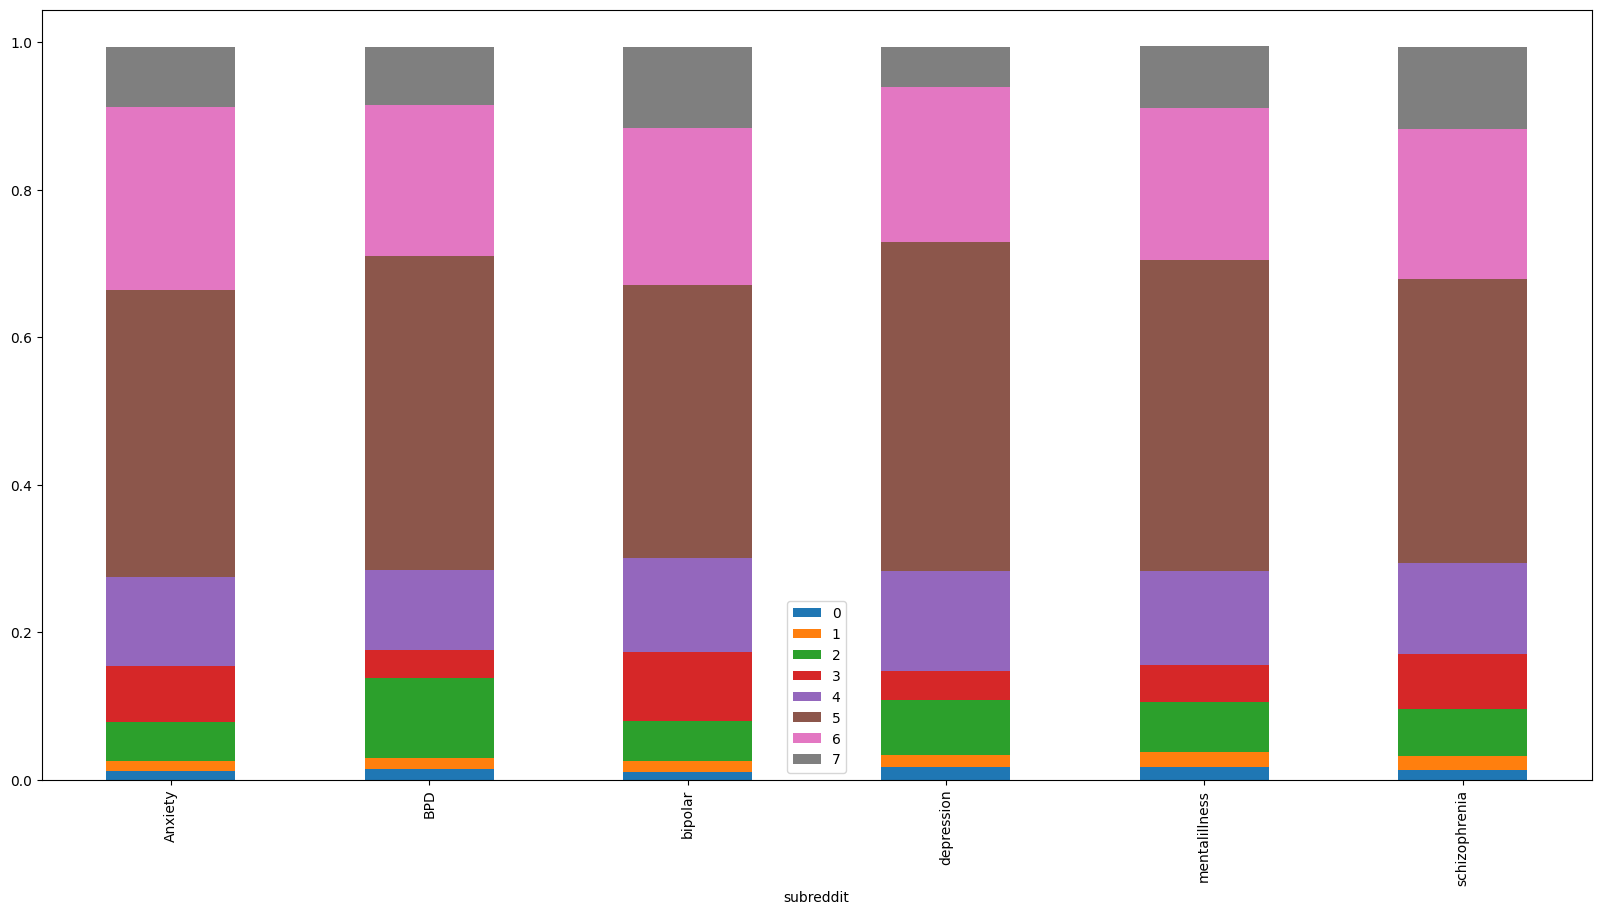

In [52]:
means = df.groupby('subreddit')[['0', '1', '2', '3', '4', '5', '6', '7']].mean()

# plot the mean of each topic per subreddit stack bar
means.plot(kind='bar', stacked=True, figsize=(20, 10))

print(means)



Los datos no arrojan conclusiones respecto a topics que puedan variar en función del foro, siguen siendo los mismos temas generales para todos los subreddits. Lo que sí se puede apreciar es una predominancia del topic 5, seguido del 6 y luego siendo similar para 7 y 4. Esto puede indicar que la mayoría de los posts (como es lógico) son de personas que describen su día a día con su enfermedad y la lucha interna que sufren.

Aunque este análisis está basado en medias de scores, veamos si "binarizando" los topics podemos ver si hay diferencias en los subreddits.

In [7]:
df = pd.read_csv('processed_data_plus.csv')
topic_scores_df = pd.read_csv('topic_scores.csv')

df = pd.concat([df, topic_scores_df], axis=1)


In [8]:
df['dominant_topic'] = df[['0', '1', '2', '3', '4', '5', '6', '7']].idxmax(axis=1)

<Axes: xlabel='subreddit'>

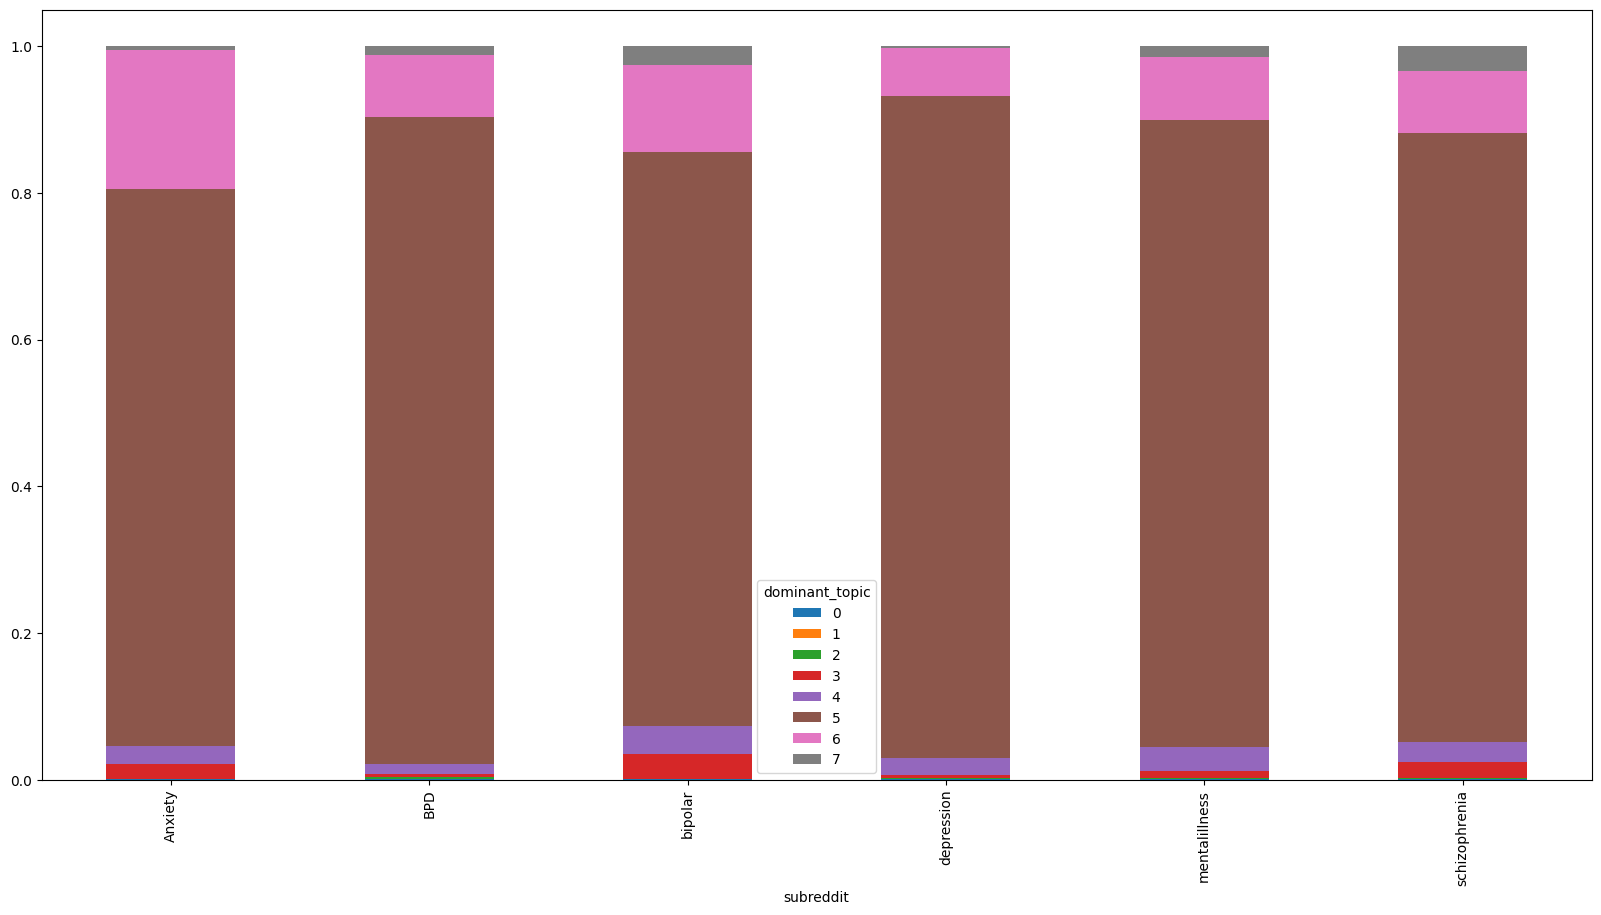

In [15]:
df.groupby('subreddit')['dominant_topic'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(20, 10))



Mismos resultados, unicamnetes haciendo más extrema la presencia del topic 5 en todos los subreddits.

Ya que el topic predominante es el 5, puede ser interesante ver el wordcloud de este topic, ya que puede definir un tema común general para todos estos subreddits.

In [18]:
df_topic5 = df[df['dominant_topic'] == '5']

texts = df_topic5['lemmas'].apply(eval).apply(lambda x: ' '.join(x)).values
texts

array(['life pointless without other anyone else think important part life relationship like absolute important really care goal life lol long end relationship like ultimate life goal wish like tho therapist ask ab life goal imagine anything without someone side',
       'cold rage hello fellow friend bpd spectrum discourage silent borderline characteristic different level experience anger wonder express healthy way find cool first become silent blame maybe maybe today maybe simply get due shortcoming understanding however find interesting someone hurt one love tend demonize extend would normally rather aggressor extreme case lead maximum expression anger know whether guy get experience well write reaction another post illustrate anger would look like maximum amount rage like blackout call cold rage sense pain whatsoever pure anger point people recognize anymore dissociate anger field view become pinpoint start breathe superficially even lash one love try calm disgusting insanity must 

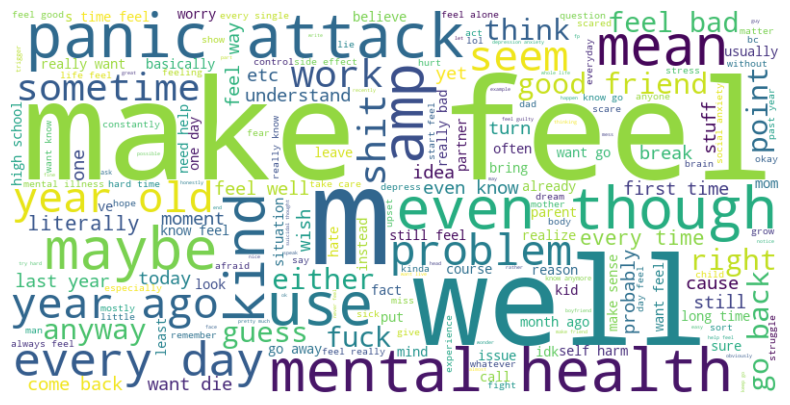

In [19]:
# now do the wordcloud
wordcloud = wordcloud.WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Como se podía ver en la distribución de los topics, el 5 parecía el dominante, y observando el wordcloud parece que definitivamente es el que toca temas más generales y comunes al ámbito de la salud mental.

### Modelo clasificador

Dada la dificultad de clasificar los posts en función de si son +18 o no, veamos si podemos clasificar los posts en función de si pertenecen a un subreddit u otro, es decir, si el modelo es capaz de detectar las diferencias en los textos de los distintos subreddits, y si es capaz de clasificar correctamente los posts. Además para esta clasificación eliminaré el subreddit general, ya que puede dificultar el entrenamiento del modelo. Finalmente con el modelo entrenado y evaluado, veamos si es capaz de clasificar los posts de r/mentalillness y ver si existen incongruencias en la clasificación.

Debido a la poca influencia que tienen los topics o los sentimientos por sus valores similares y distribuciones, no los incluiré en el modelo, pues no aportan información relevante.

In [110]:
df = pd.read_csv('processed_data_plus.csv')
df_no_mentalillness_index = df[df['subreddit'] != 'mentalillness'].index
df = df.loc[df_no_mentalillness_index]
embeddings = np.load('embeddings.npy')
embeddings = embeddings[df_no_mentalillness_index]
embeddings = torch.tensor(embeddings, dtype=torch.float32)


<Axes: xlabel='subreddit'>

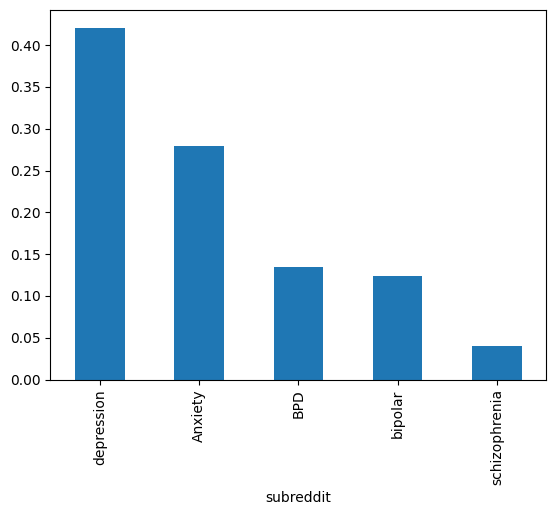

In [111]:
df['subreddit'].value_counts(normalize=True).plot(kind='bar')

In [112]:
X = embeddings
one_hot_enc = OneHotEncoder()
y = one_hot_enc.fit_transform(df[['subreddit']]).toarray()
y = torch.tensor(y, dtype=torch.float32)

In [114]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

train_ds = torch.utils.data.TensorDataset(x_train, y_train)
val_ds = torch.utils.data.TensorDataset(x_val, y_val)
test_ds = torch.utils.data.TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

In [115]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

class subredditNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden=3, hidden_dim=256, dropout=None):
        super(subredditNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout) if dropout is not None else None

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            if self.dropout is not None:
                x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = subredditNet(input_dim=x_train.shape[1], num_hidden=3, hidden_dim=128, dropout=0.4, output_dim=y_train.shape[1]).to(device)

Using device: mps


Epoch 1/15, Train Loss: 0.2703, Val Loss: 0.1757
Epoch 2/15, Train Loss: 0.1855, Val Loss: 0.1644
Epoch 3/15, Train Loss: 0.1766, Val Loss: 0.1608
Epoch 4/15, Train Loss: 0.1729, Val Loss: 0.1587
Epoch 5/15, Train Loss: 0.1696, Val Loss: 0.1573
Epoch 6/15, Train Loss: 0.1670, Val Loss: 0.1562
Epoch 7/15, Train Loss: 0.1649, Val Loss: 0.1549
Epoch 8/15, Train Loss: 0.1631, Val Loss: 0.1552
Epoch 9/15, Train Loss: 0.1607, Val Loss: 0.1541
Epoch 10/15, Train Loss: 0.1595, Val Loss: 0.1533
Epoch 11/15, Train Loss: 0.1577, Val Loss: 0.1525
Epoch 12/15, Train Loss: 0.1561, Val Loss: 0.1526
Epoch 13/15, Train Loss: 0.1548, Val Loss: 0.1536
Epoch 14/15, Train Loss: 0.1536, Val Loss: 0.1519
Epoch 15/15, Train Loss: 0.1523, Val Loss: 0.1528


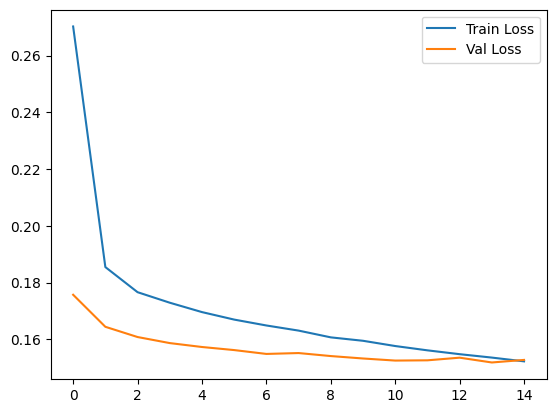

In [116]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

train_losses, val_losses = train(model, train_dl, val_dl, criterion, optimizer, device, epochs=15)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()



In [117]:
y_pred = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        output = model(X)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()
        y = y.cpu().numpy()
        output = np.round(output)
        y_pred.extend(output)
        y_true.extend(y)

print(classification_report(y_true, y_pred, target_names=one_hot_enc.categories_[0]))

               precision    recall  f1-score   support

      Anxiety       0.88      0.88      0.88     16124
          BPD       0.90      0.73      0.81      7679
      bipolar       0.84      0.73      0.79      7171
   depression       0.87      0.88      0.88     24190
schizophrenia       0.88      0.56      0.69      2358

    micro avg       0.88      0.83      0.85     57522
    macro avg       0.88      0.76      0.81     57522
 weighted avg       0.88      0.83      0.85     57522
  samples avg       0.83      0.83      0.83     57522



/opt/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Dada la dificultad de clasificación de los subreddits, el modelo ha realizado un excelente trabajo, incluso con un desbalanceo importante en los datos.

### r/mentalillness

Para finalizar el análisis, quiero centrame en analizar el subreddit general de enfermendades mentales, r/mentalillness, el proceso será el siguiente:
- Reducción de dimensionalidad mediante UMAP, para mantener la estructura de los datos y poder visualizarlos.
- Clustering mediante HDSCAN, para ver si se pueden encontrar grupos de posts en función de sus embeddings.
- Clasificación de pertenencia a un cluster con un modelo simple como un árbol de decisión o una regresión logística.
- Estudio de los shap values para ver las palabra que definen cada cluster, viendo si se puede detectar comunidades de determinados temas.
- Comparación con las predicciones del modelo de clasificación anterior.

Según casos en los que he trabajado, el mejor valor de UMAP suele ser entre 20 y 30 dimensiones, depués HDBSCAN se optimizará con optuna, para obtener el máximo silhouette score.

In [127]:
df = pd.read_csv('processed_data_plus.csv')
df_mentalillness = df[df['subreddit'] == 'mentalillness']

In [128]:
index_mentalillness = df_mentalillness.index

Utilizamos UMAP para reducir la dimensionalidad de los embeddings y poder visualizarlos en 2D.

In [129]:

UMAP = umap.UMAP(n_neighbors=50, n_components=30, metric='cosine')
embeddings = np.load('embeddings.npy')
embeddings = embeddings[index_mentalillness]
umap_embeddings = UMAP.fit_transform(embeddings)


In [130]:
umap_embeddings.shape

(10701, 30)

In [131]:
fig = px.scatter_3d(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], z=umap_embeddings[:, 2])
fig.show()

Y usamos optuna para optimizar el número de clusters en HDBSCAN, obteniendo el mejor valor de silhouette score.

In [132]:


def objective(trial):
    min_cluster_size = trial.suggest_int('min_cluster_size', 2, 100)
    min_samples = trial.suggest_int('min_samples', 1, 100)
    cluster_selection_epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 1.0)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)
    cluster_labels = clusterer.fit_predict(umap_embeddings)
    silhouette = silhouette_score(umap_embeddings, cluster_labels)
    return silhouette

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-08 17:42:19,811] A new study created in memory with name: no-name-614c6f93-1ede-41ae-ba7e-4c035a32c693
[I 2024-10-08 17:42:21,972] Trial 0 finished with value: 0.7240073680877686 and parameters: {'min_cluster_size': 66, 'min_samples': 6, 'cluster_selection_epsilon': 0.5603515720361903}. Best is trial 0 with value: 0.7240073680877686.
[I 2024-10-08 17:42:23,949] Trial 1 finished with value: 0.3716738522052765 and parameters: {'min_cluster_size': 10, 'min_samples': 20, 'cluster_selection_epsilon': 0.259389884556958}. Best is trial 0 with value: 0.7240073680877686.
[I 2024-10-08 17:42:26,016] Trial 2 finished with value: 0.3723326325416565 and parameters: {'min_cluster_size': 18, 'min_samples': 2, 'cluster_selection_epsilon': 0.7584462767860352}. Best is trial 0 with value: 0.7240073680877686.
[I 2024-10-08 17:42:28,280] Trial 3 finished with value: 0.707602322101593 and parameters: {'min_cluster_size': 33, 'min_samples': 89, 'cluster_selection_epsilon': 0.42619525985506435}. B

In [133]:
best_params = study.best_params

In [134]:

study.best_value

0.7240073680877686

Es un silhouette score relativamente bueno, por lo que los clusters deberían ser claros.

In [135]:
best_params

{'min_cluster_size': 66,
 'min_samples': 6,
 'cluster_selection_epsilon': 0.5603515720361903}

In [136]:
df_mentalillness['cluster'] = hdbscan.HDBSCAN(min_cluster_size=best_params['min_cluster_size'], min_samples=best_params['min_samples'], cluster_selection_epsilon=best_params['cluster_selection_epsilon']).fit_predict(umap_embeddings)

/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_1408/1609633877.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
fig = px.scatter_3d(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], z=umap_embeddings[:, 2], color=df_mentalillness['cluster'])
fig.show()

In [138]:
df_mentalillness['cluster'].value_counts()

cluster
1    10610
0       91
Name: count, dtype: int64

In [139]:
no_noise_index = df_mentalillness[df_mentalillness['cluster'] != -1].index
df_mentalillness = df_mentalillness.loc[no_noise_index]

In [140]:


vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df_mentalillness['lemmas'].apply(eval).apply(lambda x: ' '.join(x)))
y = df_mentalillness['cluster']

df_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

model = LogisticRegression(max_iter=200)
model.fit(df_words.values, y)

LogisticRegression(max_iter=200)

In [141]:
model.score(df_words.values, y)

0.9997196523689375

Un accuracy de prácticamente 1, por lo que las palabras son muy claras en la pertenencia a un cluster, veamos los wordclouds de cada cluster para ver si podemos identificar temas comunes.

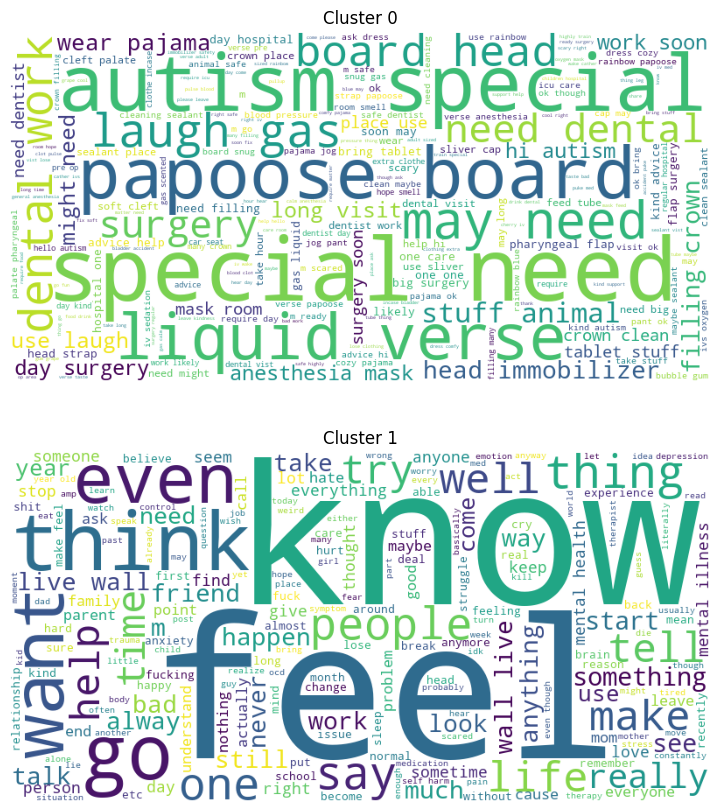

In [142]:
# print wordcloud for each cluster
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

for i in range(2):
    texts = df_mentalillness[df_mentalillness['cluster'] == i]['lemmas'].apply(eval).apply(lambda x: ' '.join(x)).values
    wc = wordcloud.WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    ax[i].imshow(wc)
    ax[i].set_title(f'Cluster {i}')
    ax[i].axis('off')

plt.show()



Al parecer el cluster minoritario 0 habla sobre special, need, autism, lo que puede indicar que es un cluster de posts de personas neurodivergentes, mientras que el cluster 1, el mayoritario, habla sobre pensar, sentir, querer, lo que puede indicar que es un cluster de posts de personas que hablan sobre sus sentimientos y pensamientos, no necesariamnete etiquetando un tema en concreto.

Finalmente utilizamos SHAP para ver las palabras que más influyen en la pertenencia a un cluster, y vemos los resultados.

In [143]:
shap.initjs()

In [144]:
explainer = shap.Explainer(model, df_words, feature_names=vectorizer.get_feature_names_out())

In [145]:
shap_values = explainer(df_words)

In [146]:
shap_values.shape

(10701, 21555)

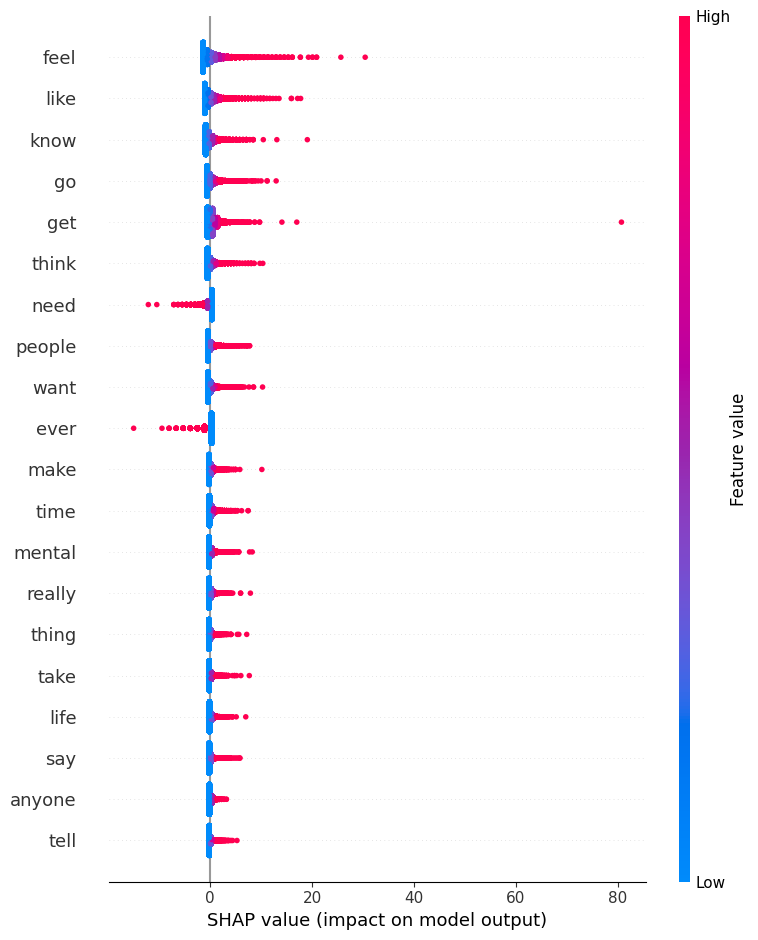

In [147]:
shap.summary_plot(shap_values, df_words, feature_names=vectorizer.get_feature_names_out())

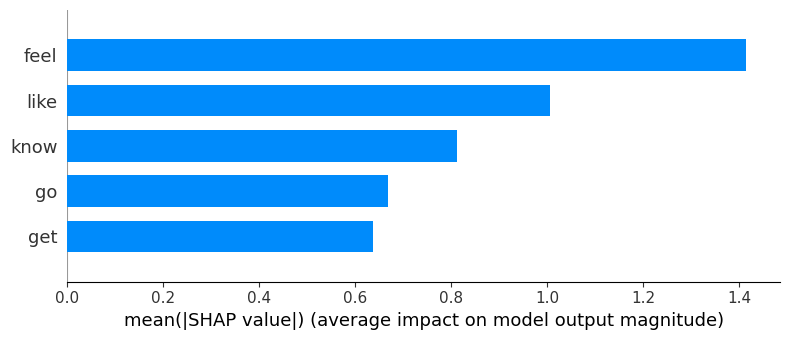

In [151]:
shap.summary_plot(shap_values, df_words, feature_names=vectorizer.get_feature_names_out(), plot_type='bar', max_display=5)


Como se podía ver en el wordcloud, las palabras más importantes para la clasificación son las más frecuentes de cada cluster, en este caso, las palabras más comunes de un cluster influyen positivamente a la pertenencia a ese cluster, y negativamente al otro.

Ahora carguemos el modelo de clasificación de subreddits y veamos como clasifica los posts de r/mentalillness.

In [152]:
subreddit_model = torch.load('subreddit_model.pt')

/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_1408/2968797312.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [153]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
subreddit_model.to(device)
preds = subreddit_model(torch.tensor(embeddings, dtype=torch.float32).to(device)).cpu().detach().numpy()

In [155]:
decoded_preds = one_hot_enc.inverse_transform(preds)



In [159]:
df_mentalillness['subreddit'] = decoded_preds.reshape(-1)


Veamos la distribución de subreddits en función del cluster, y veamos si hay alguna relación entre los clusters y los subreddits.

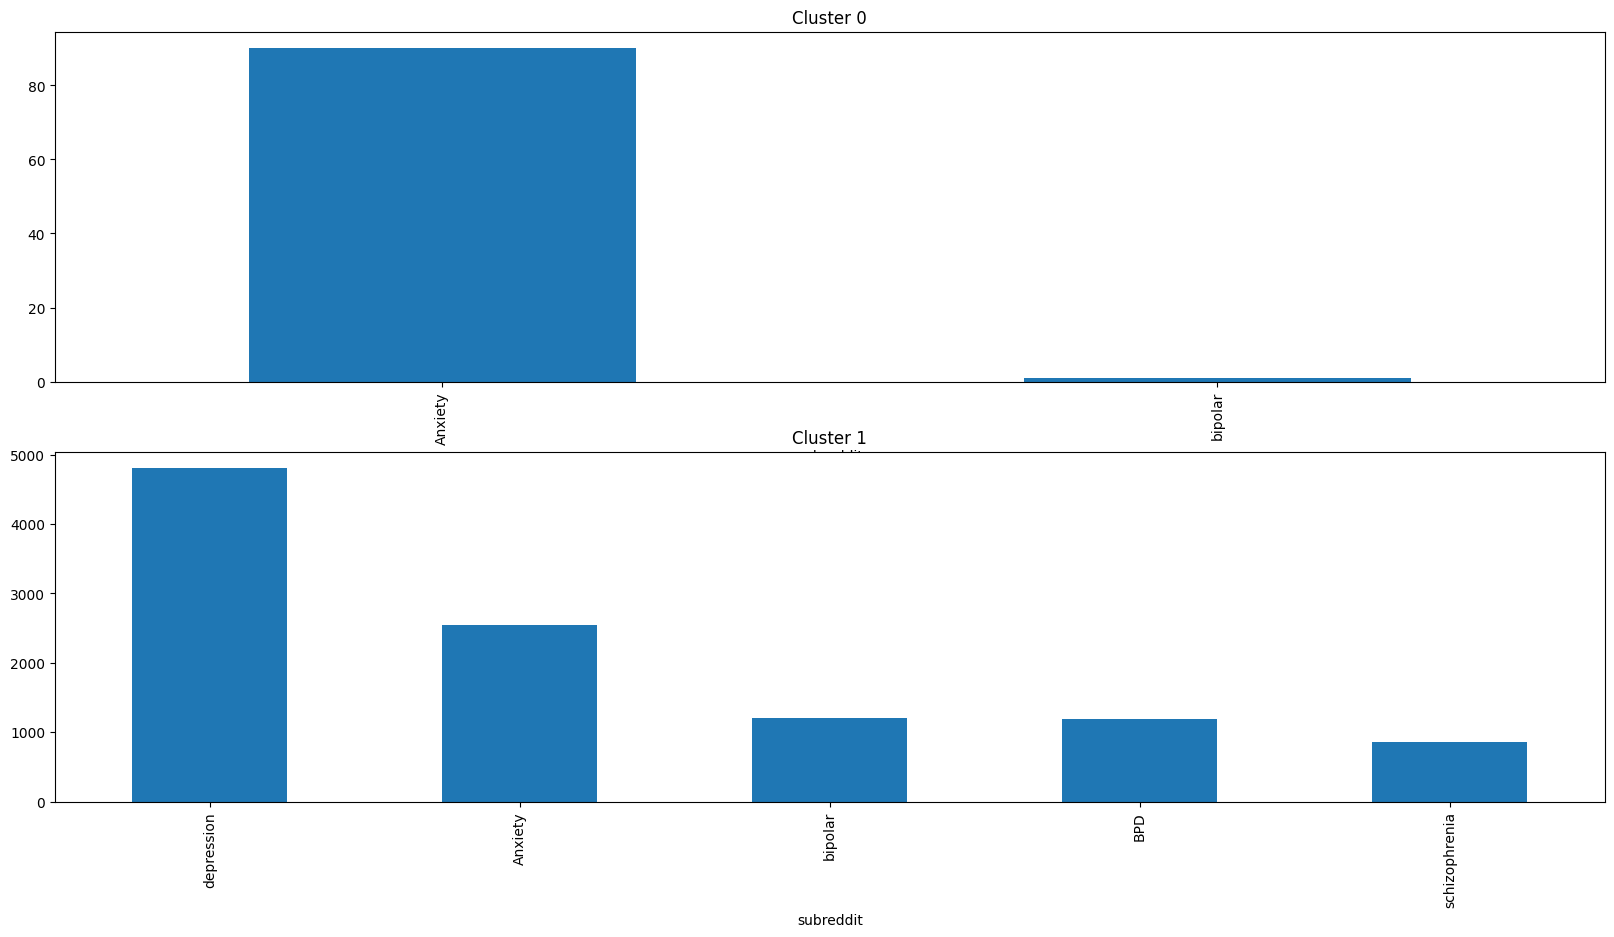

In [163]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

for i in range(2):
    df_mentalillness[df_mentalillness['cluster'] == i]['subreddit'].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set_title(f'Cluster {i}')

plt.show()



Como se puede apreciar en la distribución de subreddits por cluster, el cluster mayoritario parece seguir una distribución similar a la de los subreddits, algo claramente influenciado por el entrenamiento del modelo, pero que tiene cierto sentido pues los subreddits de este tipo de temas suelen tener posts similares. 
Finalmente en el cluster 0 minoritario, con palabras clave como autism, special o need, parece ser predominante el tema de la ansiedad, que puede estar ligada a las vivencias diarias de personas neurodivergentes.

## Conclusiones

Una vez terminado el análisis, podemos concluir los siguientes puntos:

- El sentimiento de los posts en los subreddits de enfermedades mentales es muy similar, con una distribución en forma de "U" que indica una alta polarización en los comentarios, tanto en los extremos negativos como positivos. Aunque por lo general, los posts tienden a ser más negativos que positivos, esto puede deberse a la naturaleza de los temas tratados en estos subreddits, y que los subreddits más populares tratan sobre la depresión y la ansiedad, que son enfermedades mentales que suelen asociarse con sentimientos negativos.

- La clasificación de los posts en función de si son +18 o no es una tarea complicada, sino imposible, ya que no existe una relación clara entre los sentimientos expresados en los textos y su contenido y la clasificación realizada por los moderadores de los subreddits, que puede ser, y seguramente es, subjetiva.

- Los subreddits de enfermedades mentales son muy similares en cuanto a los temas que tratan, siendo los más comunes los relacionados con las vivencias del día a día de las personas que sufren estas enfermedades, sus pensamientos y sentimientos, y la búsqueda de ayuda profesional y tratamiento y, minoritariamente, traumas de la infancia e historias de abuso. Aunque no se han encontrado diferencias claras en los temas tratados en los distintos subreddits, se ha podido identificar un cluster de posts de personas aparentemente neurodivergentes en r/mentalillness (el subreddit general del tema), que hablan sobre sus necesidades especiales y su experiencia de vida.

- A pesar de las similaridades en los temas tratados en los subreddits, el modelo de clasificación de subreddits ha sido capaz de clasificar correctamente los posts de los distintos subreddits con un accuracy aceptable, lo que indica que existen diferencias en los textos de los distintos subreddits a pesar de sus similaridades en cuanto a los temas tratados, concluyendo una distribución similar a la general en r/mentalillness en el cluster mayoritario.
